In [105]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [106]:
industries = ['construction', 'education_health_services', 'financial_activities', 'information', 
              'leisure_hospitality', 'manufacturing', 'natural_resources_mining', 'other_services', 
              'professional_business_services', 'trade_transportation_utilities']

## Arguements
__csv_file_path:__ *TYPE = STRING*, local file path for csv file to be imported as pandas dataframe to be used for modeling  

__period_of_disaster:__ *TYPE = INT*, the indexed period that the disaster occurred in, 0 based indexing with 12 periods per year  

__industry_disaster_name:__ *TYPE = STRING*, descriptive name to be used to label the csv and png files exported to current folder  

In [108]:
def sarima_search(csv_file_path, period_of_disaster, industry_disaster_name):
    
    import pandas as pd
    import numpy as np
    from datetime import datetime
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error
    from statsmodels.tsa.arima_model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    sns.set_style('whitegrid')

    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    
    
    industry_employment = pd.read_csv(csv_file_path, header=None, names=['date', 'employment'])

    industry_employment.index = pd.DatetimeIndex(start=industry_employment['date'][0], periods=len(industry_employment['date']), freq = 'M')

    industry_employment.drop(columns='date', inplace=True)

    train = industry_employment.iloc[0:period_of_disaster]

    test = industry_employment.iloc[period_of_disaster:]


    mse = 99 * (10 ** 16)
    final_p = 0
    final_d = 0
    final_q = 0

    final_P = 0
    final_D = 0
    final_Q = 0

    for p in range(4):
        for q in range(4):
            for d in range(4):
                for P in range(4):
                    for Q in range(4):
                        for D in range(4):
                            try:
                                sarima = SARIMAX(endog = train['employment'],
                                                 order = (p, d, q),              # (p, d, q)
                                                 seasonal_order = (P, D, Q, 12)) # (P, D, Q, S)

                                model = sarima.fit()

                                preds = model.predict(start = 0, end = (period_of_disaster - 1))

                                if mse > mean_squared_error(train['employment'], preds):
                                    mse = mean_squared_error(train['employment'], preds)
                                    final_q = q
                                    final_d = d
                                    final_q = q

                                    final_P = P
                                    final_D = D
                                    final_Q = Q

                            except:
                                pass

    print(f'Our model that minimizes MSE on the training data is the SARIMA({final_p}, {final_d}, {final_q})x({final_P},{final_D},{final_Q},12).')
    print(f'This model has an MSE of {mse}.')
    
    return final_p, final_d, final_q, final_P, final_D, final_Q

In [109]:
def sarima_model(p, d, q, P, D, Q, csv_file_path, period_of_disaster, industry_disaster_name):
    
    import pandas as pd
    import numpy as np
    from datetime import datetime
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error
    from statsmodels.tsa.arima_model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    sns.set_style('whitegrid')

    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    
    
    industry_employment = pd.read_csv(csv_file_path, header=None, names=['date', 'employment'])

    industry_employment.index = pd.DatetimeIndex(start=industry_employment['date'][0], periods=len(industry_employment['date']), freq = 'M')

    industry_employment.drop(columns='date', inplace=True)

    train = industry_employment.iloc[0:period_of_disaster]

    test = industry_employment.iloc[period_of_disaster:]
    
    
    sarima = SARIMAX(endog = train['employment'], 
                     order = (p, d, q), 
                     seasonal_order = (P, D, Q, 12))

    model = sarima.fit()

    preds = model.predict(start= period_of_disaster, end=48)


    plt.figure(figsize=(10,6))
    plt.plot(train['employment'], color = 'blue')
    plt.plot(test['employment'], color = 'orange')
    plt.plot(preds, color = 'green')
    plt.title(label = industry_disaster_name, fontsize=18)
    plt.savefig('./katrina_datasets_and_visuals/' + industry_disaster_name + '.png')
    plt.show();

    industry_employment['preds'] = preds
    industry_employment['residual'] = industry_employment['preds'] - industry_employment['employment']
    
    industry_employment.to_csv('./katrina_datasets_and_visuals/' + industry_disaster_name + '.csv')
    
    return industry_employment, train, test

## Construction

In [111]:
sarima_search(csv_file_path='./DisastersbyIndustry/Katrina-Industry/construction_all_employees.csv', period_of_disaster=31, industry_disaster_name='katrina_construction')

C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood opti

Our model that minimizes MSE on the training data is the SARIMA(0, 1, 3)x(2,0,0,12).
This model has an MSE of 51262501.40360815.


(0, 1, 3, 2, 0, 0)

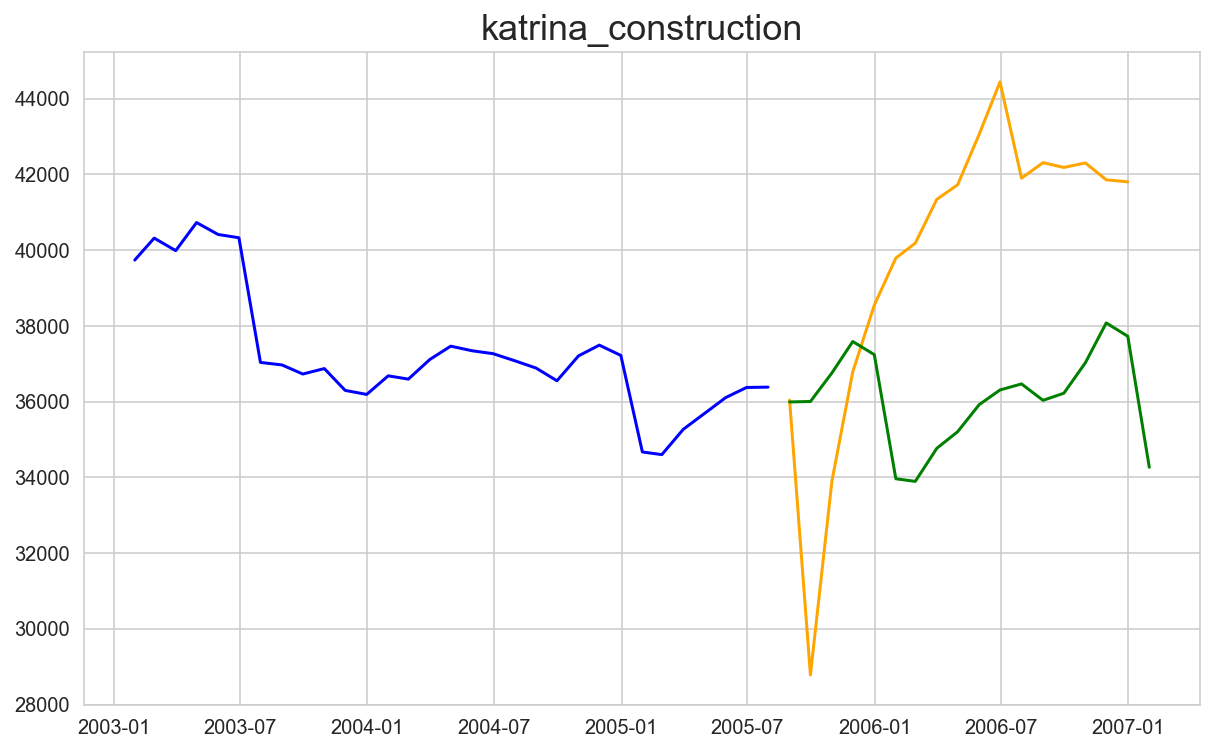

(            employment         preds     residual
 2003-01-31     39739.0           NaN          NaN
 2003-02-28     40319.0           NaN          NaN
 2003-03-31     39988.0           NaN          NaN
 2003-04-30     40730.0           NaN          NaN
 2003-05-31     40415.0           NaN          NaN
 2003-06-30     40328.0           NaN          NaN
 2003-07-31     37036.0           NaN          NaN
 2003-08-31     36969.0           NaN          NaN
 2003-09-30     36729.0           NaN          NaN
 2003-10-31     36873.0           NaN          NaN
 2003-11-30     36297.0           NaN          NaN
 2003-12-31     36190.0           NaN          NaN
 2004-01-31     36681.0           NaN          NaN
 2004-02-29     36595.0           NaN          NaN
 2004-03-31     37114.0           NaN          NaN
 2004-04-30     37465.0           NaN          NaN
 2004-05-31     37343.0           NaN          NaN
 2004-06-30     37267.0           NaN          NaN
 2004-07-31     37081.0        

In [132]:
sarima_model(2,1,3,1,1,0, csv_file_path='./DisastersbyIndustry/Katrina-Industry/construction_all_employees.csv', period_of_disaster=31, industry_disaster_name='katrina_construction')

## Education and Health Services

In [134]:
sarima_search(csv_file_path='./DisastersbyIndustry/Katrina-Industry/education_health_services_all_employees.csv', period_of_disaster=31, industry_disaster_name='katrina_edu_health_services')

C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\aidan\Anaconda3\envs\DSI-6\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood opti

Our model that minimizes MSE on the training data is the SARIMA(0, 1, 2)x(1,0,0,12).
This model has an MSE of 248156808.4946444.


(0, 1, 2, 1, 0, 0)

In [ ]:
sarima_search(csv_file_path='./DisastersbyIndustry/Katrina-Industry/education_health_services_all_employees.csv', period_of_disaster=31, industry)